In [79]:
# GOALS FOR SATURDAY
# - composite over time analysis! JOIN CHARTS
# - NEXT WEEK: check with rob/jonathon about composite analysis

# COLOR SCHEME
# blue for crime
# green for green space
# yellow/orange for strs

In [80]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text
from pyfonts import load_font

In [81]:
arrests = pd.read_csv('../data/composite/precinct_arrests.csv')

In [82]:
greenspace = pd.read_csv('../data/composite/precinct_greenspace.csv')

In [83]:
permits = pd.read_csv('../data/composite/precinct_permits.csv')

In [84]:
# Because the value ranges are so different between all three factors, I'll be taking the averages of each and calculating how much each precinct's factors vary from the average.

In [104]:
def percent_change(df, value_col='Value'):
    mean_val = df[value_col].mean()
    df['PercChange'] = ((df[value_col] - mean_val) / mean_val) * 100
    return df

### arrests

In [105]:
arrests = arrests.drop(columns='Unnamed: 0')

KeyError: "['Unnamed: 0'] not found in axis"

In [106]:
percent_change(arrests, value_col='objid')

,PRECINCT,objid,PercChange
0,CENTRAL,13152,-21.743981
1,EAST,16499,-1.828919
2,HERMITAGE,21611,28.588110
3,MADISON,15432,-8.177700
4,MIDTOWN,13102,-22.041487
5,NORTH,19585,16.533161
7,SOUTH,25295,50.508364
8,WEST,9775,-41.837547


In [107]:
arrests_pct = arrests.drop(columns='objid')

In [108]:
arrests = arrests.drop(columns='PercChange')

### greenspace

In [109]:
greenspace = greenspace.drop(columns='Unnamed: 0')

KeyError: "['Unnamed: 0'] not found in axis"

In [110]:
percent_change(greenspace, value_col='Mileage')

,PRECINCT,Mileage,PercChange
0,CENTRAL,7.983308,-77.591065
1,EAST,20.242662,-43.179383
2,HERMITAGE,40.014362,12.319254
3,MADISON,24.063903,-32.453263
4,MIDTOWN-HILLS,20.303061,-43.009845
5,NORTH,54.296966,52.410143
6,SOUTH,40.456146,13.559329
7,WEST,77.644064,117.944829


In [128]:
mask = (greenspace['PRECINCT'].isin(['MIDTOWN-HILLS']))
greenspace.loc[mask, 'PRECINCT'] = greenspace.loc[mask, 'PRECINCT'] = 'MIDTOWN'

In [129]:
greenspace_pct = greenspace.drop(columns='Mileage')

In [130]:
greenspace = greenspace.drop(columns='PercChange')

KeyError: "['PercChange'] not found in axis"

### permits

In [113]:
permits = permits.drop(columns='Unnamed: 0')

KeyError: "['Unnamed: 0'] not found in axis"

In [114]:
mask = (permits['PRECINCT'].isin(['MIDTOWN-HILLS']))
permits.loc[mask, 'PRECINCT'] = permits.loc[mask, 'PRECINCT'] = 'MIDTOWN'

In [115]:
percent_change(permits, value_col='Permit__')

,PRECINCT,Permit__,PercChange
0,CENTRAL,1556,65.027178
1,EAST,1536,62.906006
2,HERMITAGE,363,-61.500729
3,MADISON,151,-83.985152
4,MIDTOWN,1743,84.860135
5,NORTH,1360,44.239692
6,SOUTH,448,-52.485748
7,WEST,386,-59.061381


In [116]:
permits_pct = permits.drop(columns='Permit__')

In [117]:
permits = permits.drop(columns='PercChange')

### Joining Percent Changes

In [171]:
# Excluding 'Outside Nash'
arrests_pct = arrests_pct.loc[arrests_pct['PRECINCT'].isin(['CENTRAL', 'EAST', 'HERMITAGE', 'MADISON', 'MIDTOWN', 'NORTH', 'SOUTH', 'WEST'])]

In [172]:
# Joining arrests and greenspace
arrests_grnspc = (pd.merge(left=arrests_pct, right=greenspace_pct, how='left', on='PRECINCT')
                    .rename(columns={'PercChange_x' : 'Arrests', 'PercChange_y' : 'Green Space'})
                    )

In [173]:
arrests_grnspc

,PRECINCT,PercChange
0,CENTRAL,-21.743981
1,EAST,-1.828919
2,HERMITAGE,28.588110
3,MADISON,-8.177700
4,MIDTOWN,-22.041487
5,NORTH,16.533161
6,SOUTH,50.508364
7,WEST,-41.837547


In [174]:
# Joining permits
composite_pcts = (pd.merge(left=arrests_grnspc, right=permits_pct, how='left', on='PRECINCT')
                    .rename(columns={'PercChange' : 'Permits'})
                    .drop(columns='Unnamed: 0')
                    )

KeyError: "['Unnamed: 0'] not found in axis"

In [135]:
composite_pcts

,PRECINCT,Arrests,Green Space,Permits
0,CENTRAL,-21.743981,-77.591065,65.027178
1,EAST,-1.828919,-43.179383,62.906006
2,HERMITAGE,28.588110,12.319254,-61.500729
3,MADISON,-8.177700,-32.453263,-83.985152
4,MIDTOWN,-22.041487,NaN,84.860135
5,NORTH,16.533161,52.410143,44.239692
6,SOUTH,50.508364,13.559329,-52.485748
7,WEST,-41.837547,117.944829,-59.061381


### Joining

In [136]:
# Excluding 'Outside Nash'
arrests = arrests.loc[arrests['PRECINCT'].isin(['CENTRAL', 'EAST', 'HERMITAGE', 'MADISON', 'MIDTOWN', 'NORTH', 'SOUTH', 'WEST'])]

In [144]:
# Joining arrests and greenspace
arrests_grnspc = (pd.merge(left=arrests, right=greenspace, how='left', on='PRECINCT')
                    .rename(columns={'objid' : 'Arrests'})
                    )

In [145]:
arrests_grnspc

,PRECINCT,Arrests,Mileage
0,CENTRAL,13152,7.983308
1,EAST,16499,20.242662
2,HERMITAGE,21611,40.014362
3,MADISON,15432,24.063903
4,MIDTOWN,13102,20.303061
5,NORTH,19585,54.296966
6,SOUTH,25295,40.456146
7,WEST,9775,77.644064


In [146]:
# Joining permits
composite = (pd.merge(left=arrests_grnspc, right=permits, how='left', on='PRECINCT')
                    .rename(columns={'Permit__' : 'Permits'})
                    # .drop(columns='Unnamed: 0')
                    )

In [147]:
composite

,PRECINCT,Arrests,Mileage,Permits
0,CENTRAL,13152,7.983308,1556
1,EAST,16499,20.242662,1536
2,HERMITAGE,21611,40.014362,363
3,MADISON,15432,24.063903,151
4,MIDTOWN,13102,20.303061,1743
5,NORTH,19585,54.296966,1360
6,SOUTH,25295,40.456146,448
7,WEST,9775,77.644064,386


In [151]:
comp_melt = pd.melt(composite, id_vars='PRECINCT', value_vars=['Arrests', 'Mileage', 'Permits'],
                    var_name='category', value_name='values')

In [152]:
comp_melt

,PRECINCT,category,values
0,CENTRAL,Arrests,13152.000000
1,EAST,Arrests,16499.000000
2,HERMITAGE,Arrests,21611.000000
3,MADISON,Arrests,15432.000000
4,MIDTOWN,Arrests,13102.000000
5,NORTH,Arrests,19585.000000
6,SOUTH,Arrests,25295.000000
7,WEST,Arrests,9775.000000
8,CENTRAL,Mileage,7.983308
9,EAST,Mileage,20.242662


#### Z score standardization

In [156]:
metrics = composite[['Arrests', 'Mileage', 'Permits']]
comp_zscore = (metrics - metrics.mean()) / metrics.std()
comp_zscore['PRECINCT'] = composite['PRECINCT']

In [193]:
comp_zscore = comp_zscore.rename(columns={'Mileage':'Green Space (mi)'})

In [194]:
comp_zscore

,Arrests,Green Space (mi),Permits,PRECINCT
0,-0.717941,-1.231641,0.927299,CENTRAL
1,-0.060387,-0.685408,0.897051,EAST
2,0.943919,0.195550,-0.877012,HERMITAGE
3,-0.270010,-0.515147,-1.197644,MADISON
4,-0.727764,-0.682717,1.210121,MIDTOWN
5,0.545890,0.831932,0.630866,NORTH
6,1.667680,0.215234,-0.748456,SOUTH
7,-1.381388,1.872197,-0.842226,WEST


In [195]:
comp_zscore_melt = pd.melt(comp_zscore, id_vars='PRECINCT', value_vars=['Arrests', 'Green Space (mi)', 'Permits'],
                    var_name='category', value_name='values')

In [196]:
comp_zscore_melt

,PRECINCT,category,values
0,CENTRAL,Arrests,-0.717941
1,EAST,Arrests,-0.060387
2,HERMITAGE,Arrests,0.943919
3,MADISON,Arrests,-0.270010
4,MIDTOWN,Arrests,-0.727764
5,NORTH,Arrests,0.545890
6,SOUTH,Arrests,1.667680
7,WEST,Arrests,-1.381388
8,CENTRAL,Green Space (mi),-1.231641
9,EAST,Green Space (mi),-0.685408


### Min Max Normalization

In [165]:
# If I decide I want to use this method I need to write a function and apply it intentionally

In [164]:
metrics.mean()

Arrests    16806.375000
Mileage       35.625559
Permits      942.875000
dtype: float64

In [158]:
comp_minmax = (metrics - metrics.mean()) / metrics.std()
comp_minmax['PRECINCT'] = composite['PRECINCT']

In [159]:
comp_minmax

,Arrests,Mileage,Permits,PRECINCT
0,-0.717941,-1.231641,0.927299,CENTRAL
1,-0.060387,-0.685408,0.897051,EAST
2,0.943919,0.195550,-0.877012,HERMITAGE
3,-0.270010,-0.515147,-1.197644,MADISON
4,-0.727764,-0.682717,1.210121,MIDTOWN
5,0.545890,0.831932,0.630866,NORTH
6,1.667680,0.215234,-0.748456,SOUTH
7,-1.381388,1.872197,-0.842226,WEST


In [162]:
# comp_minmax_melt = pd.melt(comp_minmax, id_vars='PRECINCT', value_vars=['Arrests', 'Mileage', 'Permits'],
#                     var_name='category', value_name='values')

### Visuals

In [168]:
comp_melt_pcts = pd.melt(composite_pcts, id_vars='PRECINCT', value_vars=['Arrests', 'Green Space', 'Permits'],
                    var_name='category', value_name='counts')

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Arrests', 'Green Space', 'Permits']"

In [169]:
comp_melt_pcts

,PRECINCT,category,counts
0,CENTRAL,Arrests,-11.992743
1,EAST,Arrests,10.403872
2,HERMITAGE,Arrests,44.611072
3,MADISON,Arrests,3.263989
4,MIDTOWN,Arrests,-12.327321
5,NORTH,Arrests,31.053993
6,OUTSIDE NASH,Arrests,-99.685497
7,SOUTH,Arrests,69.262740
8,WEST,Arrests,-34.590105
9,CENTRAL,Green Space,-77.591065


#### Bar Perc. Change Chart and Corr

In [24]:
# Theme
colors = ["#032c3c", "#325847", '#f29544']
sns.set_palette(sns.color_palette(colors))

# Style
sns.set(rc={'axes.facecolor':'#eaeaea', 
            "axes.edgecolor" : '032c3c',
            "axes.labelcolor" : '032c3c',
            'figure.facecolor':'#eaeaea',
            'grid.color' : "#032c3c"})

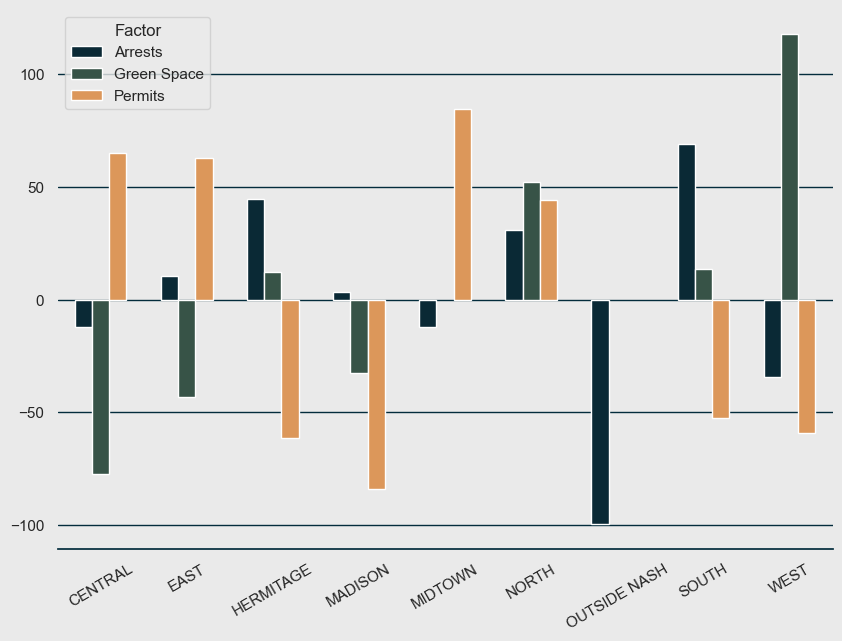

In [69]:
plt.figure(figsize=(10, 7))
sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(
    x="PRECINCT", 
    y="counts", 
    data=comp_melt_pcts,
    hue = 'category',
    width=0.6
)
ax.set_xlabel("", fontsize = 14)
ax.set_ylabel("", fontsize = 14)
plt.xticks(rotation=30)
plt.legend(title='Factor', loc='upper left')
sns.despine(ax=ax, left=True)

##### Z score barchart

(-2.0, 2.0348760262181895)

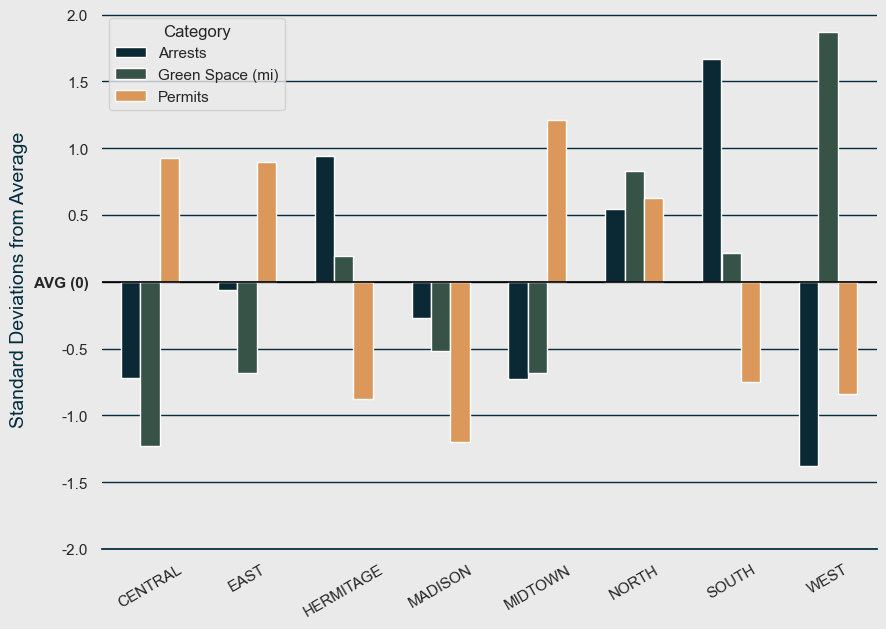

In [225]:
plt.figure(figsize=(10, 7))
sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(
    x="PRECINCT", 
    y="values", 
    data=comp_zscore_melt,
    hue = 'category',
    width=0.6
)
ax.set_xlabel("", fontsize = 14)
ax.set_ylabel("Standard Deviations from Average", fontsize = 14)
plt.axhline(0, color='black', linewidth=1.2)

plt.xticks(rotation=30)

plt.yticks(ticks=[-2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0], labels=['-2.0', '-1.5', '-1.0', '-0.5', 'AVG (0)', '0.5', '1.0', '1.5', '2.0'])
new_labels = [
    label.set_fontweight('bold') or label  # set property and return label
    if tick == 0 else label
    for label, tick in zip(ax.get_yticklabels(), ax.get_yticks())
] 
ax.set_yticklabels(new_labels)

plt.legend(title='Category', loc='upper left')
sns.despine(ax=ax, left=True)
plt.ylim(bottom=-2)

SyntaxError: invalid syntax (1939165396.py, line 1)

### Correlation Values

In [184]:
composite_pcts

,PRECINCT,objid,Mileage,Permit__
0,CENTRAL,13152,7.983308,1556
1,EAST,16499,20.242662,1536
2,HERMITAGE,21611,40.014362,363
3,MADISON,15432,24.063903,151
4,MIDTOWN,13102,20.303061,1743
5,NORTH,19585,54.296966,1360
6,SOUTH,25295,40.456146,448
7,WEST,9775,77.644064,386


In [183]:
composite

,PRECINCT,Arrests,Mileage,Permits
0,CENTRAL,13152,7.983308,1556
1,EAST,16499,20.242662,1536
2,HERMITAGE,21611,40.014362,363
3,MADISON,15432,24.063903,151
4,MIDTOWN,13102,20.303061,1743
5,NORTH,19585,54.296966,1360
6,SOUTH,25295,40.456146,448
7,WEST,9775,77.644064,386


In [189]:
composite_pcts[['objid', 'Mileage']].corr()

,objid,Mileage
objid,1.000000,-0.003854
Mileage,-0.003854,1.000000


In [179]:
composite[['Arrests', 'Mileage']].corr()

,Arrests,Mileage
Arrests,1.000000,-0.003854
Mileage,-0.003854,1.000000


In [188]:
composite_pcts[['objid', 'Permit__']].corr()

,objid,Permit__
objid,1.00000,-0.26363
Permit__,-0.26363,1.00000


In [187]:
composite[['Arrests', 'Permits']].corr()

,Arrests,Permits
Arrests,1.00000,-0.26363
Permits,-0.26363,1.00000
